# 1. 기본 설정

In [1]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00


In [79]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import random
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### data 불러오기

In [4]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [5]:
csv_to_parquet('/content/drive/MyDrive/항공기/open/train.csv', 'train')
csv_to_parquet('/content/drive/MyDrive/항공기/open/test.csv', 'test')

train Done.
test Done.


In [6]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('/content/drive/MyDrive/항공기/open/sample_submission.csv', index_col = 0)

#EDA

**column**
*   ID : 샘플 고유 id
*  Month: 해당 항공편의 출발 월
* Day_of_Month: Month에 해당하는 월의 날짜
* Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (현지 시각, HH:MM 형식)
* Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (현지 시각, HH:MM 형식)
* Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨)
* Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨)
* Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
* Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
* Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
* Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
* Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
* Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
* Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
* Airline: 해당 항공편을 운항하는 항공사
* Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드
(IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
* Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
* Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
* Delay: 항공편 지연 여부 (Not_Delayed, Delayed)<br>
    - **예측해야 하는 타깃**<br>
    - 다수의 데이터에 레이블이 존재하지 않음<br>
    - 준지도학습을 통해 레이블링 가능

## train

### 단변량 분석

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [8]:
train.nunique()

ID                          1000000
Month                            12
Day_of_Month                     31
Estimated_Departure_Time       1365
Estimated_Arrival_Time         1428
Cancelled                         1
Diverted                          1
Origin_Airport                  374
Origin_Airport_ID               374
Origin_State                     52
Destination_Airport             375
Destination_Airport_ID          375
Destination_State                52
Distance                       1597
Airline                          28
Carrier_Code(IATA)               11
Carrier_ID(DOT)                  28
Tail_Number                    6430
Delay                             2
dtype: int64

In [9]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
train.head(3)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None


In [ ]:
origin_train = train.groupby(['Origin_Airport_ID', 'Origin_Airport'])[['ID']].count().reset_index().drop('ID', axis=1)
count = 0

for i in origin_train['Origin_Airport_ID'].value_counts():
    if i != 1:
        count += 1

if count == 0:
    print('train : Origin_Airport_ID와 Origin_Airport는 1:1 대응이다.')
else:
    print('train : Origin_Airport_ID와 Origin_Airport는 1:1 대응이 아니다.')


destination_train = train.groupby(['Destination_Airport', 'Destination_Airport_ID'])[['ID']].count().reset_index().drop('ID', axis=1)
count = 0

for i in destination_train['Destination_Airport'].value_counts():
    if i != 1:
        count += 1

if count == 0:
    print('train : Destination_Airport와 Destination_Airport_ID는 1:1 대응이다.')
else:
    print('train : Destination_Airport와 Destination_Airport_ID는 1:1 대응이 아니다.')

airline_train = train.groupby(['Airline', 'Carrier_ID(DOT)'])[['ID']].count().reset_index().drop('ID', axis=1)
count = 0

for i in airline_train['Airline'].value_counts():
    if i != 1:
        count += 1

if count == 0:
    print('train : Airline와 Carrier_ID(DOT)는 1:1 대응이다.')
else:
    print('train : Airline와 Carrier_ID(DOT)는 1:1 대응이 아니다.')



train : Origin_Airport_ID와 Origin_Airport는 1:1 대응이다.
train : Destination_Airport와 Destination_Airport_ID는 1:1 대응이다.
train : Airline와 Carrier_ID(DOT)는 1:1 대응이다.


10    0.101509
12    0.099690
11    0.096710
9     0.095566
8     0.089258
4     0.083030
1     0.077656
7     0.077543
5     0.074533
3     0.072338
6     0.072307
2     0.059860
Name: Month, dtype: float64
--------------------------------------------------


<Axes: xlabel='Month', ylabel='count'>

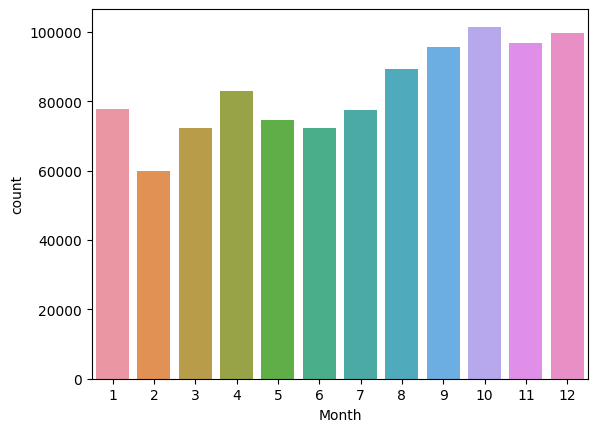

In [ ]:
print(train['Month'].value_counts()/train.shape[0])
print('-'*50)
sns.countplot(x = train['Month'])

1     2505.032258
2     2137.857143
3     2333.483871
4     2767.666667
5     2404.290323
6     2410.233333
7     2501.387097
8     2879.290323
9     3185.533333
10    3274.483871
11    3223.666667
12    3215.806452
Name: Month, dtype: float64
---------------------------------------------------------------------------


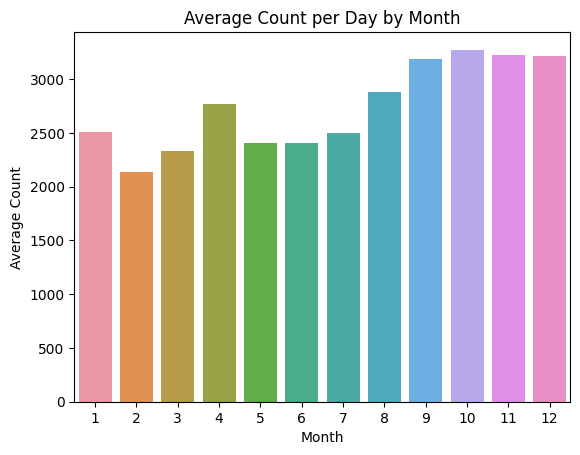

In [ ]:
month_count = train['Month'].value_counts().sort_index()
day_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
avg_month = month_count / day_in_month
print(avg_month)

print('-' * 75)

sns.barplot(x=avg_month.index, y=avg_month.values)
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.title('Average Count per Day by Month')
plt.show()

ORD    0.050436
ATL    0.044140
DEN    0.040300
LAX    0.031825
DFW    0.030879
         ...   
ADK    0.000014
GST    0.000013
DLG    0.000009
AKN    0.000008
BFM    0.000006
Name: Origin_Airport, Length: 374, dtype: float64


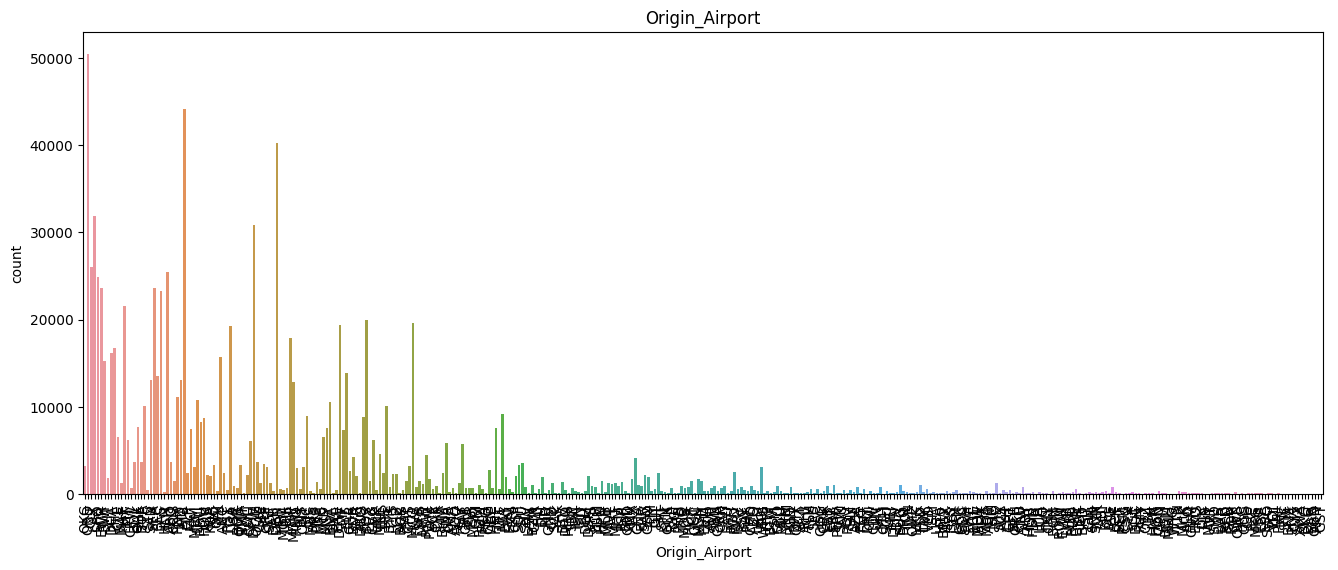

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
California                                        0.103482
Texas                                             0.089074
Florida                                           0.066426
Illinois                                          0.058765
New York                                          0.043613
Georgia                                           0.042244
Colorado                                          0.039795
North Carolina                                    0.035411
Virginia                                          0.034088
Washington                                        0.025555
Pennsylvania                                      0.023776
Nevada                                            0.023459
Arizona                                           0.022485
Michigan                                          0.022441
New

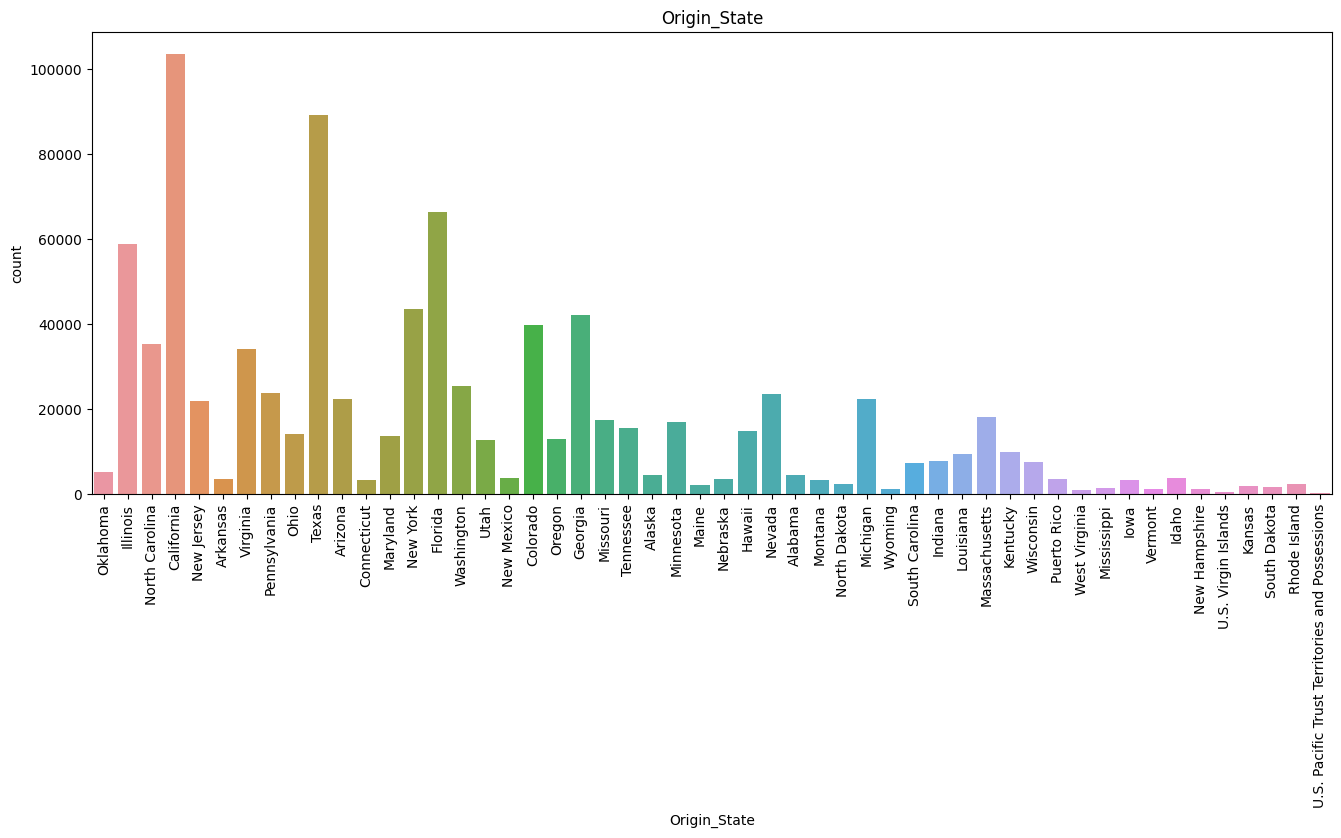

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ORD    0.050171
ATL    0.043626
DEN    0.039693
LAX    0.031936
DFW    0.030183
         ...   
BFM    0.000011
DLG    0.000008
GST    0.000006
AKN    0.000003
YNG    0.000001
Name: Destination_Airport, Length: 375, dtype: float64


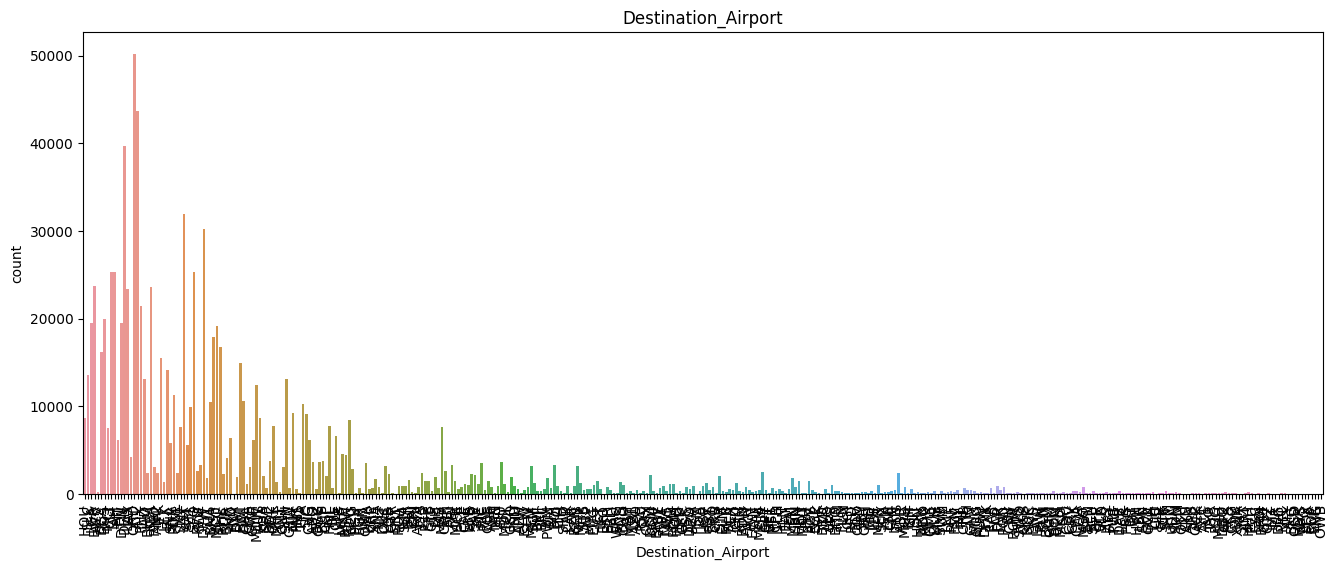

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
California                                        0.104347
Texas                                             0.087950
Florida                                           0.066474
Illinois                                          0.058323
New York                                          0.044144
Georgia                                           0.041620
Colorado                                          0.039490
North Carolina                                    0.035089
Virginia                                          0.034272
Washington                                        0.025666
Nevada                                            0.023661
Pennsylvania                                      0.023660
Michigan                                          0.022452
Arizona                                           0.022448
New

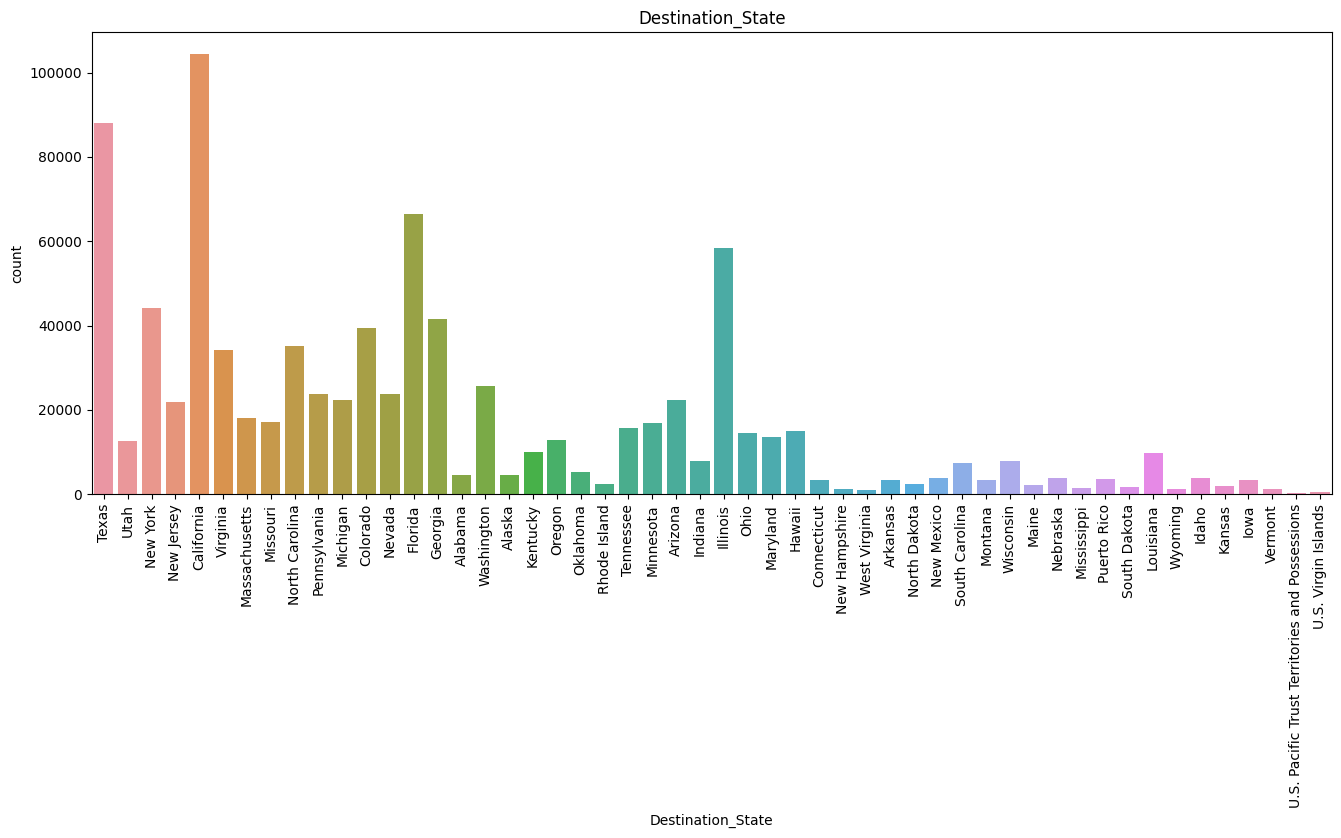

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Southwest Airlines Co.                       0.182113
Delta Air Lines Inc.                         0.089750
SkyWest Airlines Inc.                        0.086867
United Air Lines Inc.                        0.084070
American Airlines Inc.                       0.082755
JetBlue Airways                              0.041643
Republic Airlines                            0.033582
Alaska Airlines Inc.                         0.029141
Envoy Air                                    0.027455
Spirit Air Lines                             0.024998
Comair Inc.                                  0.024723
Mesa Airlines Inc.                           0.024679
Endeavor Air Inc.                            0.023172
ExpressJet Airlines Inc.                     0.020144
Frontier Airlines Inc.                       0.017415
Allegiant Air      

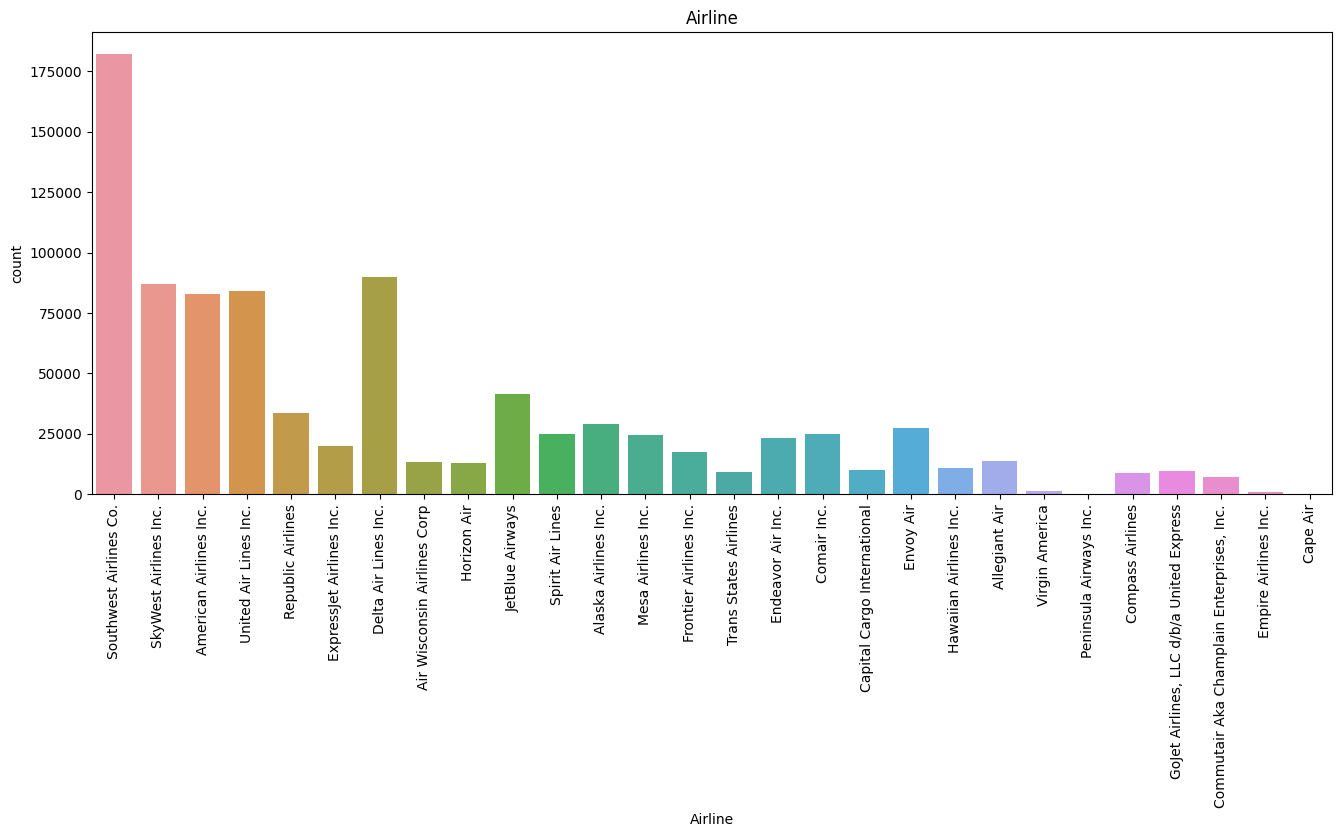

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
19393.0    0.182025
19790.0    0.089958
20304.0    0.086902
19977.0    0.083984
19805.0    0.082860
20409.0    0.041615
20452.0    0.033351
19930.0    0.029085
20398.0    0.027474
20416.0    0.024983
20397.0    0.024838
20378.0    0.024699
20363.0    0.023113
20366.0    0.020197
20436.0    0.017440
20368.0    0.013739
20046.0    0.013319
19687.0    0.013107
19690.0    0.010921
20427.0    0.009962
20500.0    0.009532
20237.0    0.009321
21167.0    0.008813
20445.0    0.007124
21171.0    0.001324
20263.0    0.001052
20225.0    0.000142
20253.0    0.000123
Name: Carrier_ID(DOT), dtype: float64


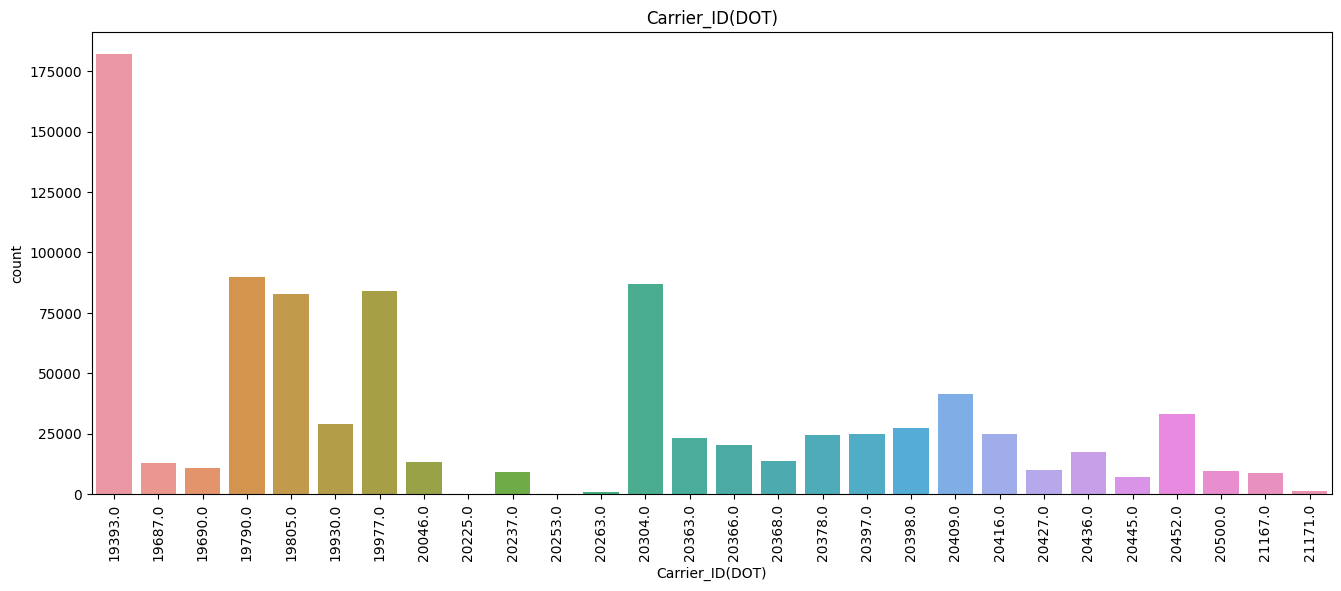

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UA    0.206211
WN    0.182189
AA    0.182099
DL    0.161266
AS    0.048155
B6    0.041477
NK    0.025074
F9    0.017458
G4    0.013746
HA    0.012019
VX    0.001316
Name: Carrier_Code(IATA), dtype: float64


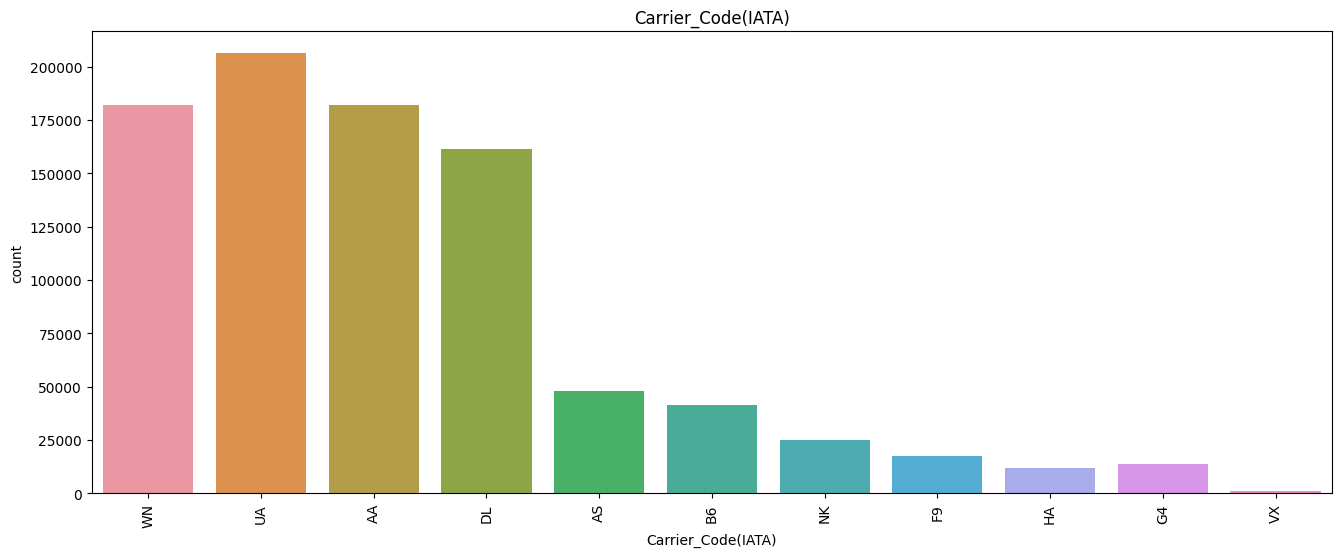

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_ID(DOT)', 'Carrier_Code(IATA)']
for column in col:
    print(train[column].value_counts() / train.shape[0])
    plt.figure(figsize=(16, 6))
    sns.countplot(x=train[column])
    plt.xticks(rotation=90)
    plt.title(column)
    plt.show()
    print('-' * 170)


count    1000000.000000
mean         784.078499
std          590.790469
min           16.000000
25%          350.000000
50%          623.000000
75%         1020.000000
max         5095.000000
Name: Distance, dtype: float64


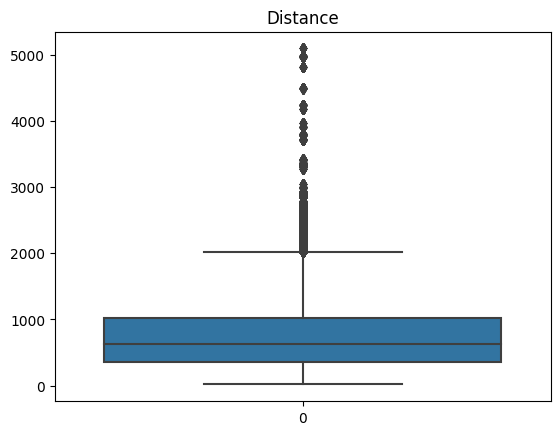

In [ ]:
sns.boxplot(train['Distance'])
plt.title('Distance')
print(train['Distance'].describe())

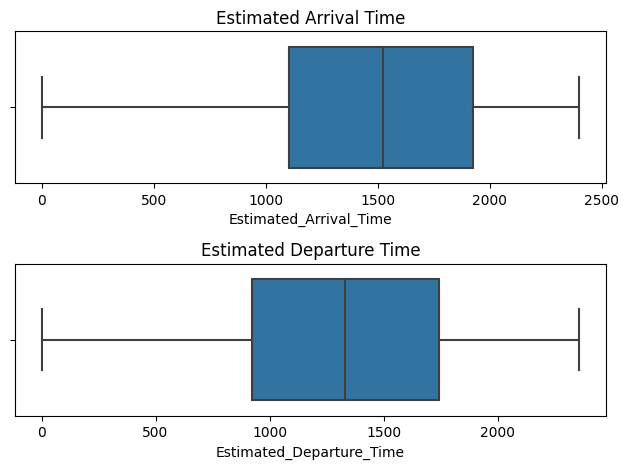

count    890960.000000
mean       1493.295934
std         520.803494
min           1.000000
25%        1105.000000
50%        1524.000000
75%        1924.000000
max        2400.000000
Name: Estimated_Arrival_Time, dtype: float64
count    890981.000000
mean       1341.153019
std         489.814011
min           1.000000
25%         925.000000
50%        1332.000000
75%        1742.000000
max        2359.000000
Name: Estimated_Departure_Time, dtype: float64


In [ ]:
plt.subplot(2, 1, 1)
sns.boxplot(data=train, x='Estimated_Arrival_Time')
plt.title('Estimated Arrival Time')

plt.subplot(2, 1, 2)
sns.boxplot(data=train, x='Estimated_Departure_Time')
plt.title('Estimated Departure Time')

plt.tight_layout()
plt.show()

print(train['Estimated_Arrival_Time'].describe())
print(train['Estimated_Departure_Time'].describe())

### 이변량 분석

In [ ]:
train.corr()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
Month,1.000000,0.010119,-0.004424,-0.005983,NaN,NaN,-0.009490,-0.008929,-0.013824,0.024550
Day_of_Month,0.010119,1.000000,-0.001210,-0.001897,NaN,NaN,-0.001064,0.000521,0.002719,-0.001519
Estimated_Departure_Time,-0.004424,-0.001210,1.000000,0.683152,NaN,NaN,-0.025891,0.023767,-0.010714,-0.009664
Estimated_Arrival_Time,-0.005983,-0.001897,0.683152,1.000000,NaN,NaN,-0.008247,0.015027,0.013754,-0.002654
Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diverted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin_Airport_ID,-0.009490,-0.001064,-0.025891,-0.008247,NaN,NaN,1.000000,0.020514,0.062215,-0.029483
Destination_Airport_ID,-0.008929,0.000521,0.023767,0.015027,NaN,NaN,0.020514,1.000000,0.064447,-0.031580
Distance,-0.013824,0.002719,-0.010714,0.013754,NaN,NaN,0.062215,0.064447,1.000000,-0.112459
Carrier_ID(DOT),0.024550,-0.001519,-0.009664,-0.002654,NaN,NaN,-0.029483,-0.031580,-0.112459,1.000000


<Axes: >

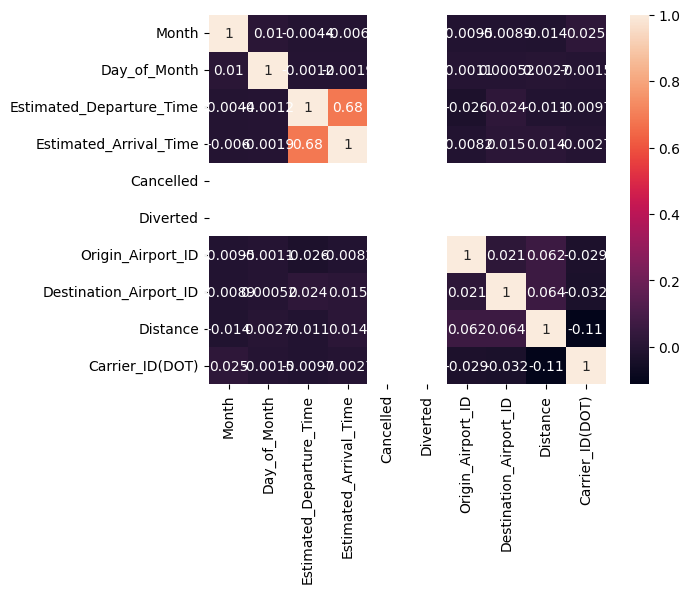

In [ ]:
sns.heatmap(train.corr(), annot=True)

## test

### 단변량분석

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  891016 non-null   float64
 4   Estimated_Arrival_Time    890952 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              893495 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         893477 non-null   object 
 13  Distance                  10

In [ ]:
test.nunique()

ID                          1000000
Month                            12
Day_of_Month                     31
Estimated_Departure_Time       1413
Estimated_Arrival_Time         1436
Cancelled                         1
Diverted                          1
Origin_Airport                  379
Origin_Airport_ID               379
Origin_State                     52
Destination_Airport             377
Destination_Airport_ID          377
Destination_State                52
Distance                       1601
Airline                          28
Carrier_Code(IATA)               18
Carrier_ID(DOT)                  28
Tail_Number                    6493
dtype: int64

In [ ]:
test.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,891016.000000,890952.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,890994.000000
mean,6.694222,15.609095,1377.120331,1522.026944,0.0,0.0,12687.984806,12699.560390,795.849058,20001.307653
std,3.476341,8.706486,487.590917,528.269560,0.0,0.0,1509.299455,1512.906515,594.558756,402.903185
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,3.000000,8.000000,954.750000,1127.000000,0.0,0.0,11292.000000,11292.000000,358.000000,19790.000000
50%,7.000000,16.000000,1405.000000,1555.000000,0.0,0.0,12889.000000,12889.000000,634.000000,19977.000000
75%,10.000000,23.000000,1800.000000,1944.000000,0.0,0.0,14027.000000,14057.000000,1034.000000,20378.000000
max,12.000000,31.000000,2400.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
origin_test = test.groupby(['Origin_Airport_ID', 'Origin_Airport'])[['ID']].count().reset_index().drop('ID', axis=1)
count = 0

for i in origin_test['Origin_Airport_ID'].value_counts():
    if i != 1:
        count += 1

if count == 0:
    print('test : Origin_Airport_ID와 Origin_Airport는 1:1 대응이다.')
else:
    print('test : Origin_Airport_ID와 Origin_Airport는 1:1 대응이 아니다.')


destination_test = test.groupby(['Destination_Airport', 'Destination_Airport_ID'])[['ID']].count().reset_index().drop('ID', axis=1)
count = 0

for i in destination_test['Destination_Airport'].value_counts():
    if i != 1:
        count += 1

if count == 0:
    print('test : Destination_Airport와 Destination_Airport_ID는 1:1 대응이다.')
else:
    print('test : Destination_Airport와 Destination_Airport_ID는 1:1 대응이 아니다.')

airline_test = test.groupby(['Airline', 'Carrier_ID(DOT)'])[['ID']].count().reset_index().drop('ID', axis=1)
count = 0

for i in airline_test['Airline'].value_counts():
    if i != 1:
        count += 1

if count == 0:
    print('test : Airline와 Carrier_ID(DOT)는 1:1 대응이다.')
else:
    print('test : Airline와 Carrier_ID(DOT)는 1:1 대응이 아니다.')


test : Origin_Airport_ID와 Origin_Airport는 1:1 대응이다.
test : Destination_Airport와 Destination_Airport_ID는 1:1 대응이다.
test : Airline와 Carrier_ID(DOT)는 1:1 대응이다.


3     0.118420
12    0.094617
10    0.092691
11    0.088729
8     0.087185
9     0.085496
4     0.078113
7     0.075775
1     0.073937
6     0.073036
5     0.071551
2     0.060450
Name: Month, dtype: float64
--------------------------------------------------


<Axes: xlabel='Month', ylabel='count'>

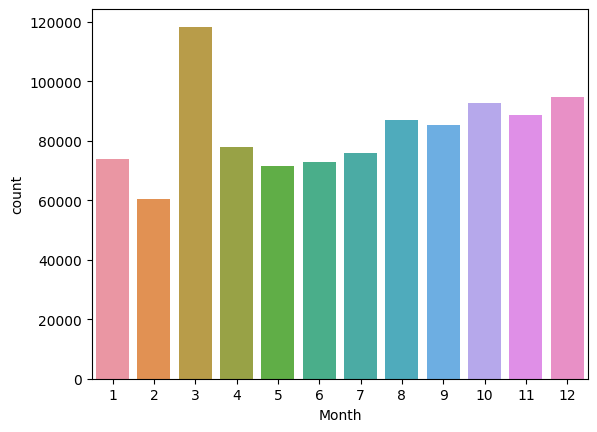

In [ ]:
print(test['Month'].value_counts()/test.shape[0])
print('-'*50)
sns.countplot(x = test['Month'])


1     2385.064516
2     2158.928571
3     3820.000000
4     2603.766667
5     2308.096774
6     2434.533333
7     2444.354839
8     2812.419355
9     2849.866667
10    2990.032258
11    2957.633333
12    3052.161290
Name: Month, dtype: float64
---------------------------------------------------------------------------


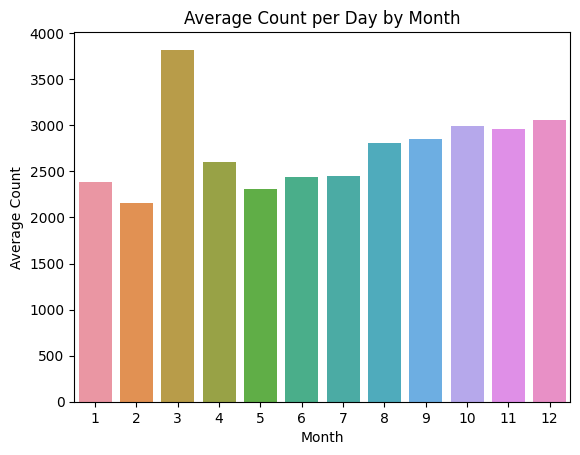

In [ ]:
month_count = test['Month'].value_counts().sort_index()
day_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
avg_month = month_count / day_in_month
print(avg_month)
print('-' * 75)

sns.barplot(x=avg_month.index, y=avg_month.values)
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.title('Average Count per Day by Month')
plt.show()

ORD    0.053133
ATL    0.043018
DEN    0.041126
DFW    0.033541
LAX    0.031027
         ...   
DDC    0.000005
AKN    0.000005
GST    0.000003
DEC    0.000002
YNG    0.000001
Name: Origin_Airport, Length: 379, dtype: float64


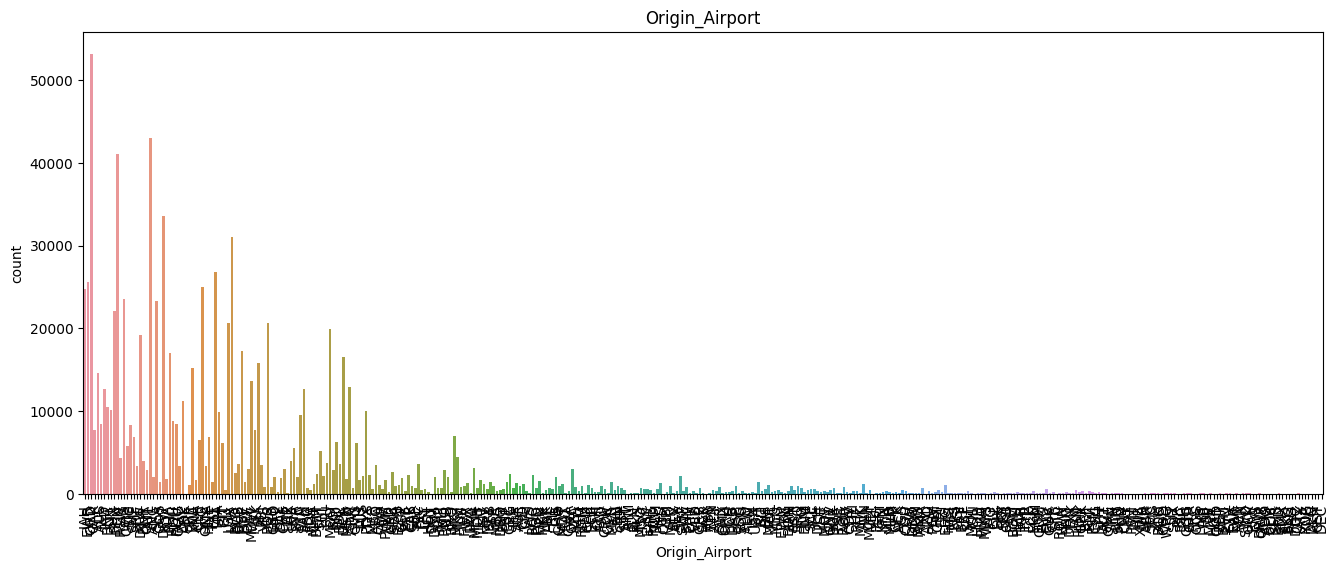

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
California                                        0.101904
Texas                                             0.089834
Florida                                           0.067033
Illinois                                          0.062795
New York                                          0.045430
Georgia                                           0.041234
Colorado                                          0.040971
North Carolina                                    0.035993
Virginia                                          0.034423
Washington                                        0.024971
Pennsylvania                                      0.023975
New Jersey                                        0.023598
Nevada                                            0.023527
Arizona                                           0.022327
Mic

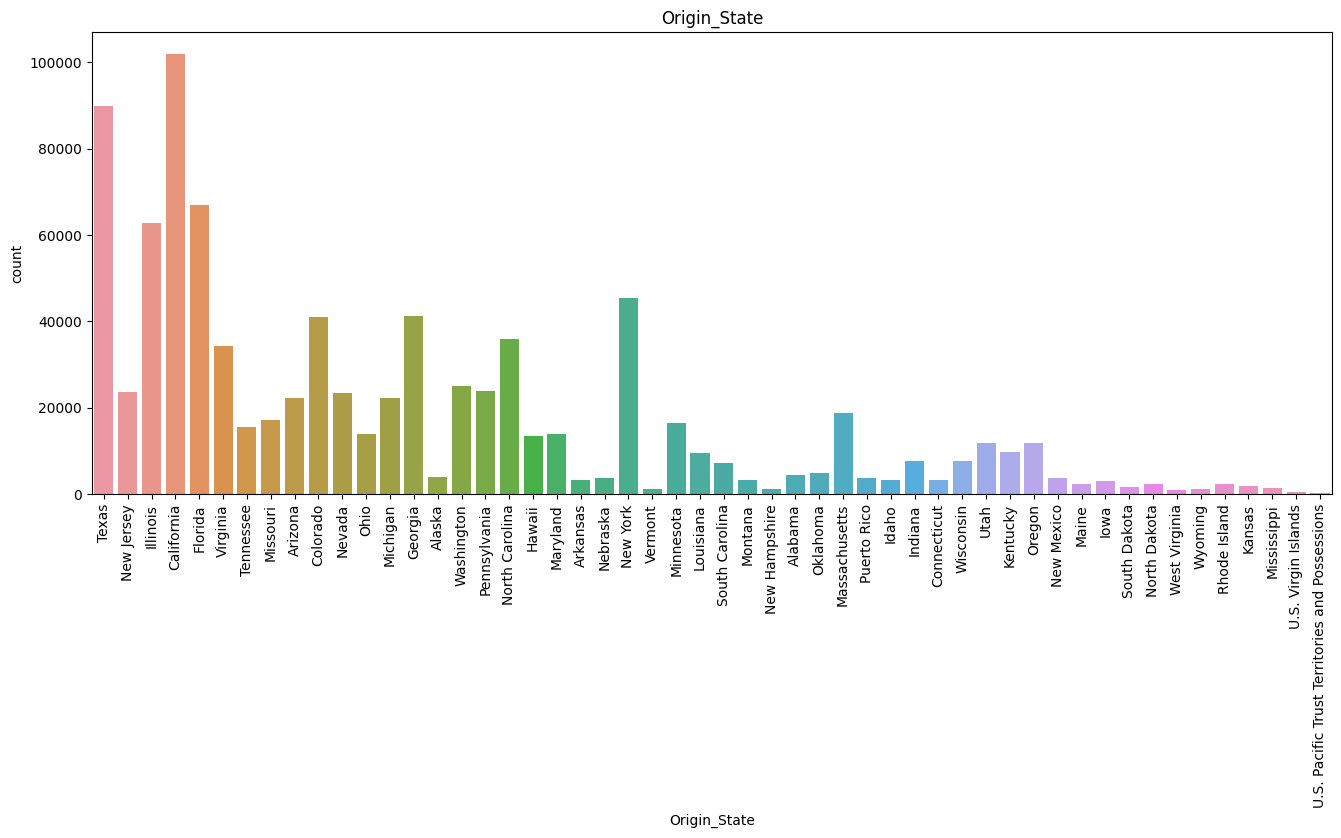

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ORD    0.050331
ATL    0.041972
DEN    0.039141
DFW    0.032322
LAX    0.032034
         ...   
WYS    0.000007
DEC    0.000006
SHR    0.000004
DLG    0.000003
GST    0.000003
Name: Destination_Airport, Length: 377, dtype: float64


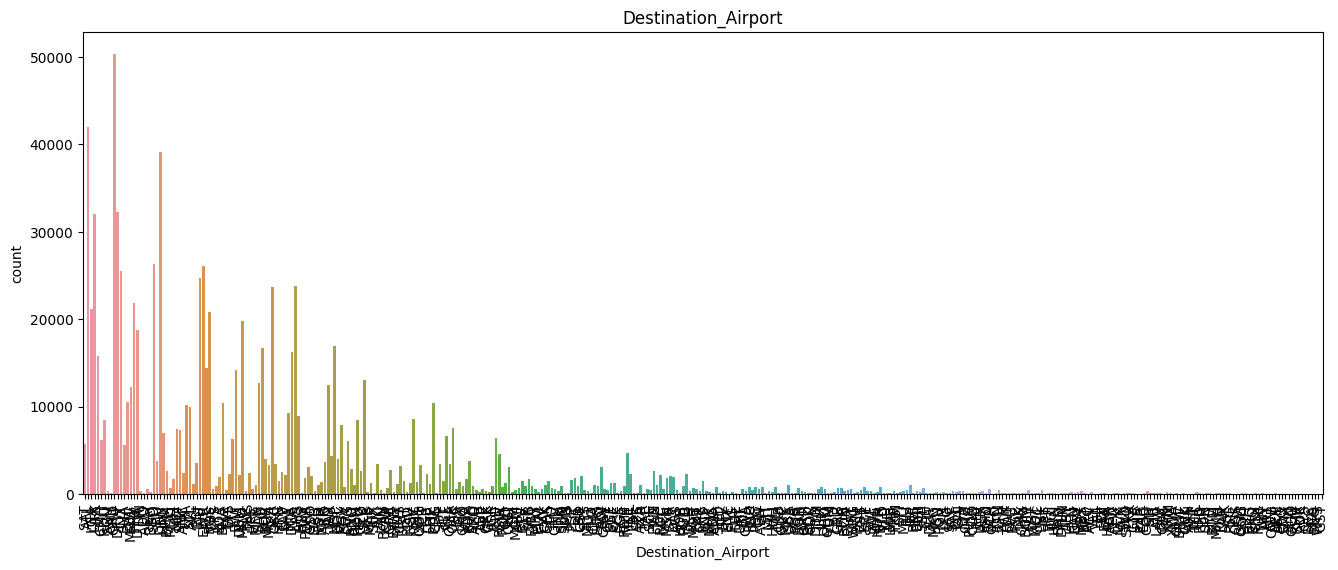

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
California                                        0.104276
Texas                                             0.088723
Florida                                           0.067675
Illinois                                          0.059279
New York                                          0.046107
Georgia                                           0.040360
Colorado                                          0.039381
North Carolina                                    0.035091
Virginia                                          0.034099
Washington                                        0.025465
New Jersey                                        0.024198
Pennsylvania                                      0.023725
Nevada                                            0.023475
Arizona                                           0.022220
Mic

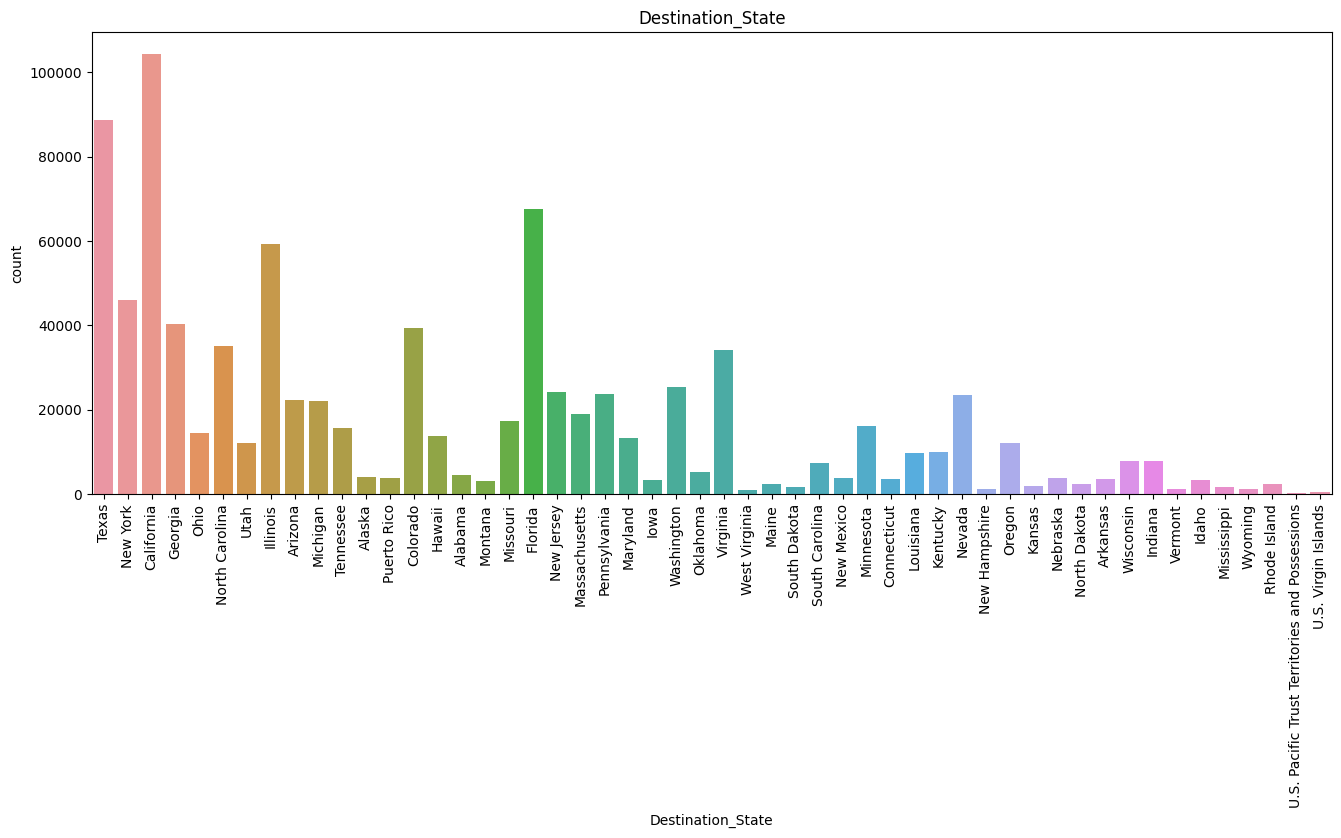

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Southwest Airlines Co.                       0.183258
Delta Air Lines Inc.                         0.086363
American Airlines Inc.                       0.086056
SkyWest Airlines Inc.                        0.085650
United Air Lines Inc.                        0.083733
JetBlue Airways                              0.044116
Republic Airlines                            0.033184
Alaska Airlines Inc.                         0.028356
Envoy Air                                    0.027977
Comair Inc.                                  0.025198
Spirit Air Lines                             0.024912
Mesa Airlines Inc.                           0.024271
Endeavor Air Inc.                            0.023006
ExpressJet Airlines Inc.                     0.020451
Frontier Airlines Inc.                       0.018920
Allegiant Air      

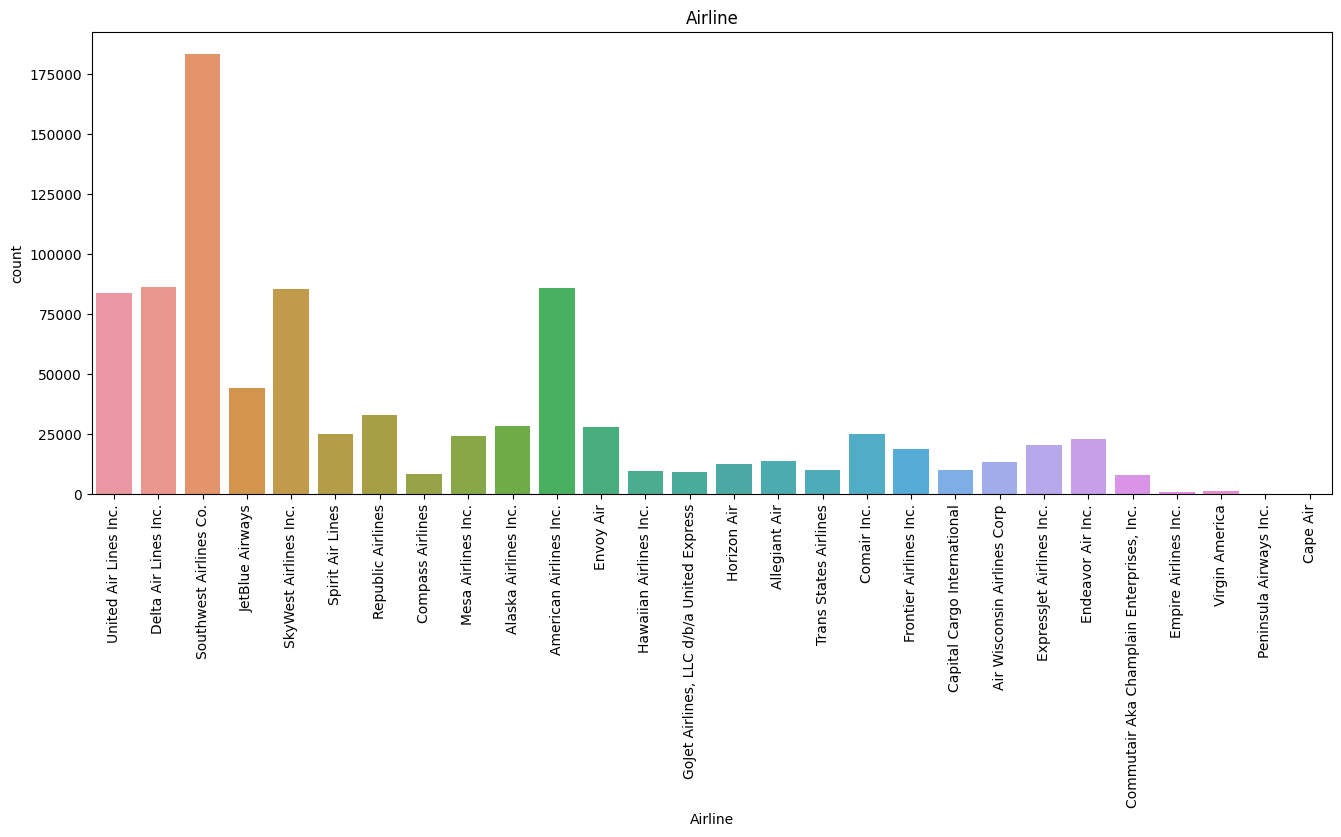

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
19393.0    0.179910
19805.0    0.087875
19790.0    0.086309
20304.0    0.086241
19977.0    0.082990
20409.0    0.044001
20452.0    0.033114
19930.0    0.028877
20398.0    0.028636
20397.0    0.026435
20416.0    0.025386
20378.0    0.024627
20363.0    0.023133
20366.0    0.020082
20436.0    0.019097
20368.0    0.014014
20046.0    0.012580
19687.0    0.011822
19690.0    0.009620
20427.0    0.009549
20237.0    0.009433
20500.0    0.008904
21167.0    0.008138
20445.0    0.007633
21171.0    0.001278
20263.0    0.001017
20225.0    0.000189
20253.0    0.000104
Name: Carrier_ID(DOT), dtype: float64


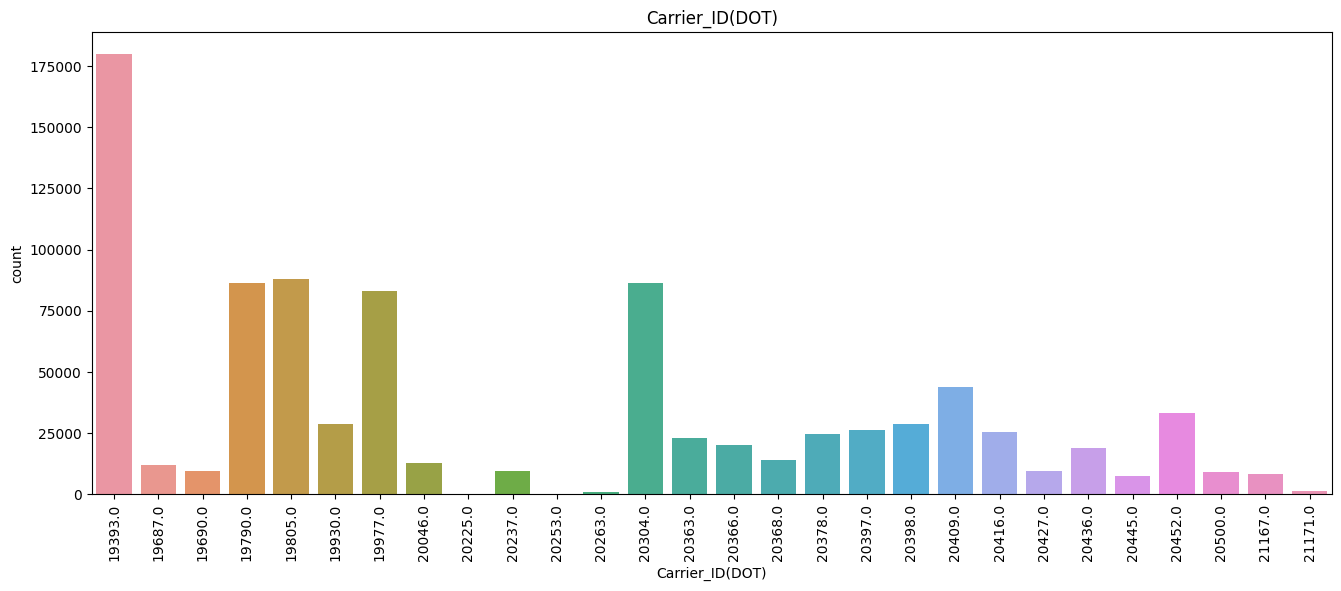

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UA    0.200174
AA    0.182635
WN    0.179818
DL    0.152685
AS    0.045966
B6    0.043958
NK    0.025579
F9    0.018982
G4    0.014061
HA    0.010684
OO    0.005111
OH    0.002517
MQ    0.002126
YV    0.001720
YX    0.001650
9E    0.001375
VX    0.001260
EV    0.000706
Name: Carrier_Code(IATA), dtype: float64


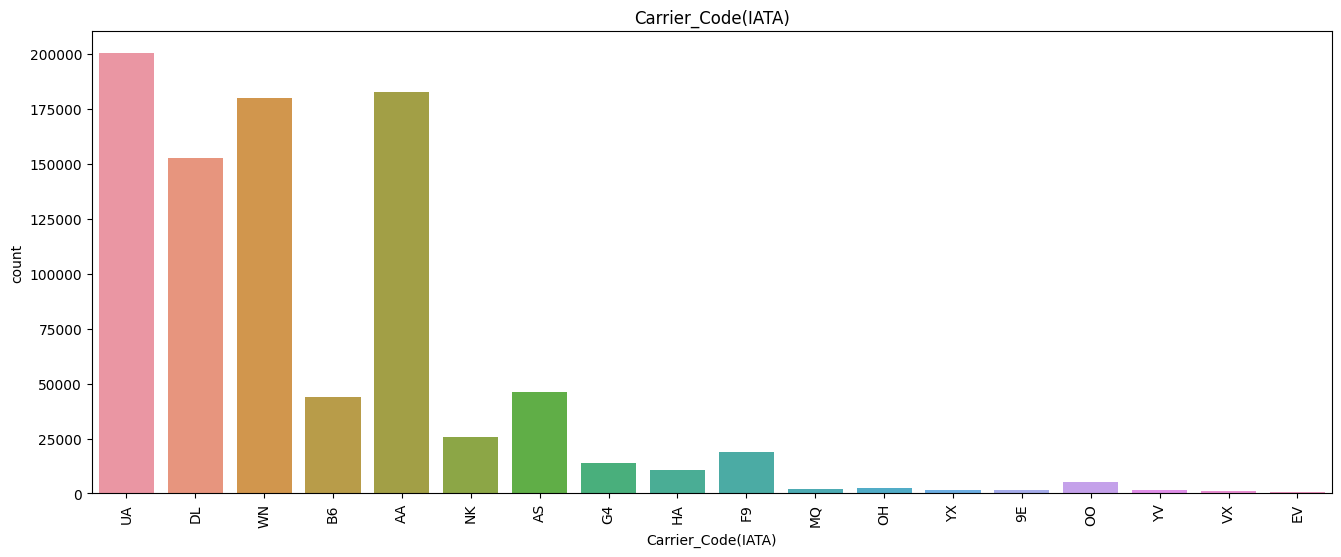

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_ID(DOT)', 'Carrier_Code(IATA)']
for column in col:
    print(test[column].value_counts() / test.shape[0])
    plt.figure(figsize=(16, 6))
    sns.countplot(x=test[column])
    plt.xticks(rotation=90)
    plt.title(column)
    plt.show()
    print('-' * 170)

count    1000000.000000
mean         795.849058
std          594.558756
min           16.000000
25%          358.000000
50%          634.000000
75%         1034.000000
max         5095.000000
Name: Distance, dtype: float64


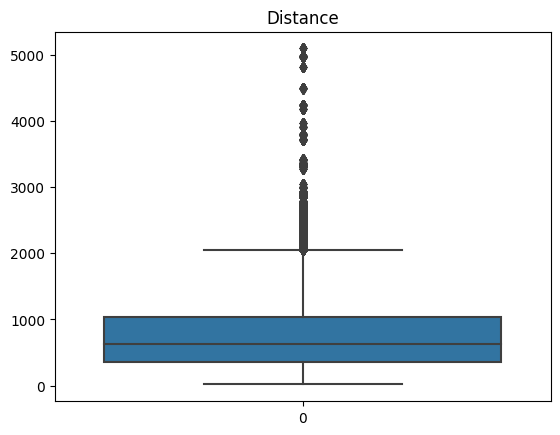

In [ ]:
sns.boxplot(test['Distance'])
plt.title('Distance')
print(test['Distance'].describe())

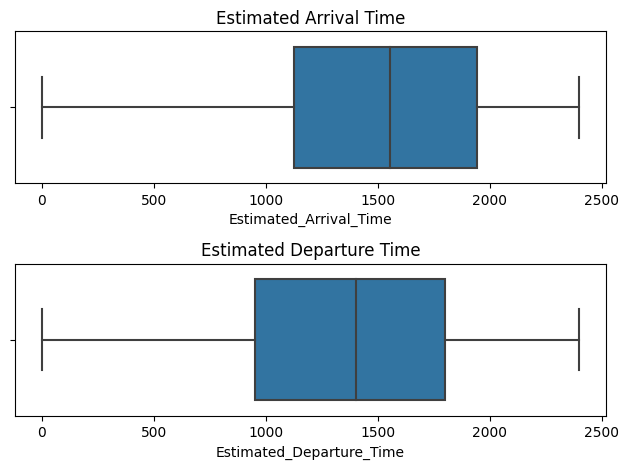

count    890952.000000
mean       1522.026944
std         528.269560
min           1.000000
25%        1127.000000
50%        1555.000000
75%        1944.000000
max        2400.000000
Name: Estimated_Arrival_Time, dtype: float64
count    891016.000000
mean       1377.120331
std         487.590917
min           1.000000
25%         954.750000
50%        1405.000000
75%        1800.000000
max        2400.000000
Name: Estimated_Departure_Time, dtype: float64


In [ ]:
plt.subplot(2, 1, 1)
sns.boxplot(data=test, x='Estimated_Arrival_Time')
plt.title('Estimated Arrival Time')

plt.subplot(2, 1, 2)
sns.boxplot(data=test, x='Estimated_Departure_Time')
plt.title('Estimated Departure Time')

plt.tight_layout()
plt.show()

print(test['Estimated_Arrival_Time'].describe())
print(test['Estimated_Departure_Time'].describe())

### 이변량분석

In [ ]:
test.corr()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
Month,1.000000,0.034503,-0.013775,-0.005056,NaN,NaN,-0.006064,-0.007283,-0.020311,0.017302
Day_of_Month,0.034503,1.000000,-0.005829,-0.004414,NaN,NaN,-0.000107,0.001381,0.001665,-0.004209
Estimated_Departure_Time,-0.013775,-0.005829,1.000000,0.647203,NaN,NaN,-0.032370,0.020536,-0.014666,-0.023187
Estimated_Arrival_Time,-0.005056,-0.004414,0.647203,1.000000,NaN,NaN,-0.012492,0.012408,0.007372,-0.012508
Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diverted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin_Airport_ID,-0.006064,-0.000107,-0.032370,-0.012492,NaN,NaN,1.000000,0.017674,0.063090,-0.029992
Destination_Airport_ID,-0.007283,0.001381,0.020536,0.012408,NaN,NaN,0.017674,1.000000,0.069005,-0.037702
Distance,-0.020311,0.001665,-0.014666,0.007372,NaN,NaN,0.063090,0.069005,1.000000,-0.118787
Carrier_ID(DOT),0.017302,-0.004209,-0.023187,-0.012508,NaN,NaN,-0.029992,-0.037702,-0.118787,1.000000


<Axes: >

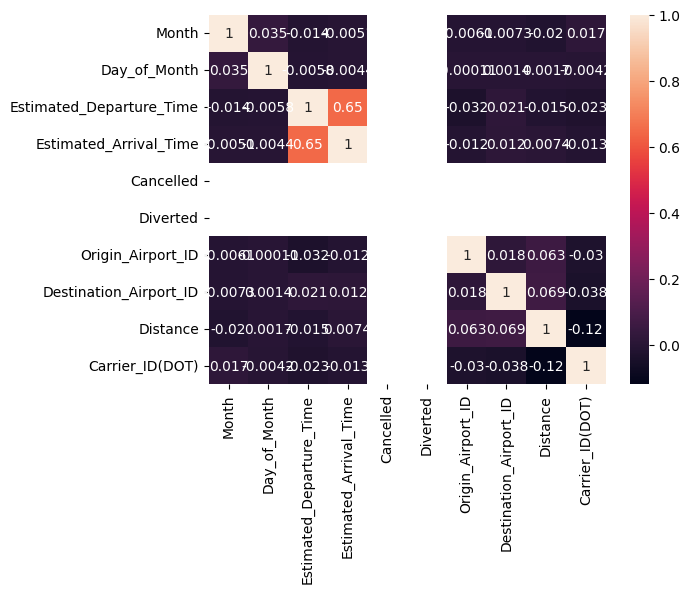

In [ ]:
sns.heatmap(test.corr(), annot=True)

# Data Pre-Processing

## 결측치 개수 확인

In [ ]:
print(train.isna().sum())
print('-'*50)
print(train.isna().sum() / train.shape[0])

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64
--------------------------------------------------
ID                          0.000000
Month                       0.000000
Day_of_Month                0.000000
Estimated_Departure_Time    0.109019
Estimated_Arrival_Time      0.109040
Cancelled                   0.000000
Diverted                    0.000000
Origin_Airpo

In [ ]:
target = 'Delay'
train[target].isna().sum()

744999

## 모두 같은 값을 가지는 열 제거

In [ ]:
# 값이 모두 0임
train['Cancelled'].value_counts(), train['Diverted'].value_counts()

(0    1000000
 Name: Cancelled, dtype: int64,
 0    1000000
 Name: Diverted, dtype: int64)

In [ ]:
train = train.drop(['Cancelled', 'Diverted'], axis=1)
test = test.drop(['Cancelled', 'Diverted'], axis=1)

### 결측치 채우기

#### 1:1 대응으로 채우기

In [ ]:
# Origin_Airport_ID가 같은 값으로 Airline 채우기
for i in range(len(train)):
    if train['Airline'][i] == None:
        for j in range(len(train)):
            if train['Tail_Number'][i] == train['Tail_Number'][j] :
                train.loc[i, 'Airline'] = train['Airline'][j]
                break
            else:
                pass


train_state = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(train)):
    if train['Origin_State'][i] == None:
        for j in range(len(train_state)):
            if train['Origin_Airport_ID'][i] == train_state['Origin_Airport_ID'][j] :
                train.loc[i, 'Origin_State'] = train_state['Origin_State'][j]
                break
            else:
                pass

tail = train.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass


train.loc[train['Airline'].isna(), 'Airline'] = 'isnull'
train.loc[train['Airline']== 'isnull', 'Airline'] = None


for i in range(len(train)):
    if train['Airline'][i] == None:
        for j in range(len(tail)):
            if train['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                train.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass


# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
train.loc[train['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
train.loc[train['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(train)):
    if train['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if train['Airline'][i] == tail['Airline'][j] :
                train.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

train_state = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(train)):
    if train['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(train_state)):
            if train['Destination_Airport_ID'][i] == train_state['Destination_Airport_ID'][j] :
                train.loc[i, 'Destination_State'] = train_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
train = train.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)', 'Cancelled', 'Diverted'], axis = 1)

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(train)):
    if train['Origin_State'][i] == None:
        for j in range(len(train_state)):
            if train['Origin_Airport_ID'][i] == train_state['Origin_Airport_ID'][j] :
                train.loc[i, 'Origin_State'] = train_state['Origin_State'][j]
                break
            else:
                pass

tail = train.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

train.loc[train['Airline'].isna(), 'Airline'] = 'isnull'
train.loc[train['Airline']== 'isnull', 'Airline'] = None


for i in range(len(train)):
    if train['Airline'][i] == None:
        for j in range(len(tail)):
            if train['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                train.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass

# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
train.loc[train['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
train.loc[train['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(train)):
    if train['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if train['Airline'][i] == tail['Airline'][j] :
                train.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

train_state = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(train)):
    if train['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(train_state)):
            if train['Destination_Airport_ID'][i] == train_state['Destination_Airport_ID'][j] :
                train.loc[i, 'Destination_State'] = train_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
train = train.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)'], axis = 1)

a = train.loc[train['Estimated_Departure_Time'].isna() & train['Estimated_Arrival_Time'].isna()]
train = train.drop(a.index , axis = 0)


In [ ]:
test_state = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(test)):
    if test['Origin_State'][i] == None:
        for j in range(len(test_state)):
            if test['Origin_Airport_ID'][i] == test_state['Origin_Airport_ID'][j] :
                test.loc[i, 'Origin_State'] = test_state['Origin_State'][j]
                break
            else:
                pass

tail = test.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass


test.loc[test['Airline'].isna(), 'Airline'] = 'isnull'
test.loc[test['Airline']== 'isnull', 'Airline'] = None


for i in range(len(test)):
    if test['Airline'][i] == None:
        for j in range(len(tail)):
            if test['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                test.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass


# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
test.loc[test['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
test.loc[test['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(test)):
    if test['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if test['Airline'][i] == tail['Airline'][j] :
                test.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

test_state = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(test)):
    if test['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(test_state)):
            if test['Destination_Airport_ID'][i] == test_state['Destination_Airport_ID'][j] :
                test.loc[i, 'Destination_State'] = test_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
test = test.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)', 'Cancelled', 'Diverted'], axis = 1)

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(test)):
    if test['Origin_State'][i] == None:
        for j in range(len(test_state)):
            if test['Origin_Airport_ID'][i] == test_state['Origin_Airport_ID'][j] :
                test.loc[i, 'Origin_State'] = test_state['Origin_State'][j]
                break
            else:
                pass

tail = test.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

test.loc[test['Airline'].isna(), 'Airline'] = 'isnull'
test.loc[test['Airline']== 'isnull', 'Airline'] = None


for i in range(len(test)):
    if test['Airline'][i] == None:
        for j in range(len(tail)):
            if test['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                test.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass

# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
test.loc[test['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
test.loc[test['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(test)):
    if test['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if test['Airline'][i] == tail['Airline'][j] :
                test.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

test_state = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(test)):
    if test['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(test_state)):
            if test['Destination_Airport_ID'][i] == test_state['Destination_Airport_ID'][j] :
                test.loc[i, 'Destination_State'] = test_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
test = test.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)'], axis = 1)

a = test.loc[test['Estimated_Departure_Time'].isna() & test['Estimated_Arrival_Time'].isna()]
test = test.drop(a.index , axis = 0)


#### KNN imputer

In [ ]:
# Estimated_Departure_Time, Estimated_Arrival_Time KNNImputer 사용
imputer = KNNImputer(n_neighbors=2)

train['Estimated_Departure_Time'] = imputer.fit_transform(train[['Estimated_Departure_Time']])
train['Estimated_Arrival_Time'] = imputer.fit_transform(train[['Estimated_Arrival_Time']])


In [ ]:
test['Estimated_Departure_Time'] = imputer.fit_transform(test[['Estimated_Departure_Time']])
test['Estimated_Arrival_Time'] = imputer.fit_transform(test[['Estimated_Arrival_Time']])

#### 최빈값으로 채우기

In [ ]:
#레이블(Delay)을 제외한 결측값이 존재하는 변수들을 학습 데이터의 최빈값으로 대체합니다
NaN_col = ['Airline','Carrier_ID(DOT)', 'Destination_State']

for col in NaN_col:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)


In [ ]:
for col in NaN_col:
    mode = test[col].mode()[0]
    test[col] = test[col].fillna(mode)


### 파생변수 생성

In [10]:
# 총 소요시간
train['Total_Time'] = None
for i in range(len(train)):
    if train['Estimated_Departure_Time'][i] > train['Estimated_Arrival_Time'][i] :
        train.loc[i, 'Total_Time'] = 2400-(train['Estimated_Arrival_Time'][i] - train['Estimated_Departure_Time'][i])
    else :
        train.loc[i, 'Total_Time'] = train['Estimated_Arrival_Time'][i] - train['Estimated_Departure_Time'][i]

test['Total_Time'] = None
for i in range(len(test)):
    if test['Estimated_Departure_Time'][i] > test['Estimated_Arrival_Time'][i] :
        test.loc[i, 'Total_Time'] = 2400-(test['Estimated_Arrival_Time'][i] - test['Estimated_Departure_Time'][i])
    else :
        test.loc[i, 'Total_Time'] = test['Estimated_Arrival_Time'][i] - test['Estimated_Departure_Time'][i]

In [ ]:
#시간과 분
train['Departure_Time'] = train['Estimated_Departure_Time'].apply(lambda x: int(x/100))
train['Departure_Minute'] = train['Estimated_Departure_Time'].apply(lambda x: int(x%100))
test['Departure_Time'] = test['Estimated_Departure_Time'].apply(lambda x: int(x/100))
test['Departure_Minute'] = test['Estimated_Departure_Time'].apply(lambda x: int(x%100))

train['Arrival_Hour'] = train['Estimated_Arrival_Time'].apply(lambda x: int(x/100))
train['Arrival_Minute'] = train['Estimated_Arrival_Time'].apply(lambda x: int(x%100))
test['Arrival_Hour'] = test['Estimated_Arrival_Time'].apply(lambda x: int(x/100))
test['Arrival_Minute'] = test['Estimated_Arrival_Time'].apply(lambda x: int(x%100))


In [ ]:
#시간 범주화

train.loc[(train['Departure_Time'] >=0) & (train['Departure_Time'] < 3), 'Departure_time'] = 1
train.loc[(train['Departure_Time'] >= 3) & (train['Departure_Time'] < 6), 'Departure_time'] = 2
train.loc[(train['Departure_Time'] >= 6) & (train['Departure_Time'] < 9), 'Departure_time'] = 3
train.loc[(train['Departure_Time'] >= 9) & (train['Departure_Time'] < 12), 'Departure_time'] = 4
train.loc[(train['Departure_Time'] >= 12) & (train['Departure_Time'] < 15), 'Departure_time'] = 5
train.loc[(train['Departure_Time'] >= 15) & (train['Departure_Time'] < 18), 'Departure_time'] = 6
train.loc[(train['Departure_Time'] >= 18) & (train['Departure_Time'] < 21), 'Departure_time'] = 7
train.loc[train['Departure_Time'] >= 21 , 'Departure_time'] = 8

test.loc[(test['Departure_Time'] >= 0) & (test['Departure_Time'] < 3), 'Departure_time'] = 1
test.loc[(test['Departure_Time'] >= 3) & (test['Departure_Time'] < 6), 'Departure_time'] = 2
test.loc[(test['Departure_Time'] >= 6) & (test['Departure_Time'] < 9), 'Departure_time'] = 3
test.loc[(test['Departure_Time'] >= 9) & (test['Departure_Time'] < 12), 'Departure_time'] = 4
test.loc[(test['Departure_Time'] >= 12) & (test['Departure_Time'] < 15), 'Departure_time'] = 5
test.loc[(test['Departure_Time'] >= 15) & (test['Departure_Time'] < 18), 'Departure_time'] = 6
test.loc[(test['Departure_Time'] >= 18) & (test['Departure_Time'] < 21), 'Departure_time'] = 7
test.loc[test['Departure_Time'] >= 21,'Departure_time'] = 8

train.loc[(train['Arrival_Hour'] >=0) & (train['Arrival_Hour'] < 3), 'Arrival_Time'] = 1
train.loc[(train['Arrival_Hour'] >= 3) & (train['Arrival_Hour'] < 6), 'Arrival_Time'] = 2
train.loc[(train['Arrival_Hour'] >= 6) & (train['Arrival_Hour'] < 9), 'Arrival_Time'] = 3
train.loc[(train['Arrival_Hour'] >= 9) & (train['Arrival_Hour'] < 12), 'Arrival_Time'] = 4
train.loc[(train['Arrival_Hour'] >= 12) & (train['Arrival_Hour'] < 15), 'Arrival_Time'] = 5
train.loc[(train['Arrival_Hour'] >= 15) & (train['Arrival_Hour'] < 18), 'Arrival_Time'] = 6
train.loc[(train['Arrival_Hour'] >= 18) & (train['Arrival_Hour'] < 21), 'Arrival_Time'] = 7
train.loc[train['Arrival_Hour'] >= 21 , 'Arrival_Time'] = 8

test.loc[(test['Arrival_Hour'] >= 0) & (test['Arrival_Hour'] < 3), 'Arrival_Time'] = 1
test.loc[(test['Arrival_Hour'] >= 3) & (test['Arrival_Hour'] < 6), 'Arrival_Time'] = 2
test.loc[(test['Arrival_Hour'] >= 6) & (test['Arrival_Hour'] < 9), 'Arrival_Time'] = 3
test.loc[(test['Arrival_Hour'] >= 9) & (test['Arrival_Hour'] < 12), 'Arrival_Time'] = 4
test.loc[(test['Arrival_Hour'] >= 12) & (test['Arrival_Hour'] < 15), 'Arrival_Time'] = 5
test.loc[(test['Arrival_Hour'] >= 15) & (test['Arrival_Hour'] < 18), 'Arrival_Time'] = 6
test.loc[(test['Arrival_Hour'] >= 18) & (test['Arrival_Hour'] < 21), 'Arrival_Time'] = 7
test.loc[test['Arrival_Hour'] >= 21,'Arrival_Time'] = 8


In [ ]:
#불필요한 행 제거
train = train.drop(['Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Day_of_Month','Tail_Number','Departure_Hour', 'Departure_Minute', 'Arrival_Hour', 'Arrival_Minute'], axis = 1)
test = test.drop(['Estimated_Departure_Time','Estimated_Arrival_Time', 'Day_of_Month', 'Tail_Number','Departure_Hour', 'Departure_Minute','Arrival_Hour', 'Arrival_Minute'], axis = 1)


In [57]:
train = pd.read_csv('/content/drive/MyDrive/항공기/train_1004.csv')

In [61]:
train = train.drop('Unnamed: 0', axis = 1)

## 범주화
이산형 변수 값 많은 것 > 빈도형 더미화\
아닌 변수 > get_dummies

### 빈도형 더미화
'Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_ID(DOT)'

In [ ]:
target = 'Delay'
X = train.drop(target, axis = 1)
y = train[target]

In [ ]:
df = pd.concat([X,test], axis = 0)
FEdf = df.loc[:,['Origin_Airport', 'Origin_State',
       'Destination_Airport', 'Destination_State', 'Airline',
       'Carrier_ID(DOT)']]
x_train_fe = X.loc[:,['Origin_Airport', 'Origin_State',
       'Destination_Airport', 'Destination_State', 'Airline',
       'Carrier_ID(DOT)']]
test_fe = test.loc[:, ['Origin_Airport', 'Origin_State',
       'Destination_Airport', 'Destination_State', 'Airline',
       'Carrier_ID(DOT)']]
for col in FEdf.columns:
    freq = FEdf[col].value_counts()
    x_train_fe[col] = x_train_fe[col].map(freq)
    test_fe[col] = test_fe[col].map(freq)

In [ ]:
test_fe_y = test.loc[:,['Month','Distance', 'Total_Time', 'departure_time', 'arrival_time']].reset_index()
test_z = pd.merge(test_fe_y, test_fe.reset_index(), on= 'index', how = 'inner')
test_z = test_z.drop('index', axis = 1)

x_train_fe_y = X.loc[:,['Month','Distance', 'Total_Time','departure_time', 'arrival_time']].reset_index()
x_train_fe= pd.merge(x_train_fe_y, x_train_fe.reset_index(), on= 'index', how = 'inner')
x_train_z = x_train_fe.drop('index', axis = 1)

### one-hot encoding
'Month','departure_time', 'arrival_time'

In [ ]:
a = 'Month','departure_time', 'arrival_time'
train_dummy = X.loc[:, a]
train_dummy = train_dummy.astype(str)
train_dummy = pd.get_dummies(train_dummy, drop_first= True).reset_index()
test_dummy = test.loc[:, a]
test_dummy = test_dummy.astype(str)
test_dummy = pd.get_dummies(test_dummy, drop_first= True).reset_index()

test_fe_y = test.drop(['Month','departure_time', 'arrival_time'], axis = 1).reset_index()
x_train_fe_y = X.drop(['Month','departure_time', 'arrival_time'], axis = 1).reset_index()
x_train_k = pd.merge(x_train_fe_y, train_dummy, on= 'index', how = 'inner')
test_k = pd.merge(test_fe_y, test_dummy, on= 'index', how = 'inner')

x_train_k = x_train_k.drop('index', axis = 1)
test_k = test_k.drop('index', axis = 1)

## 정규화

### MinMaxScaler

In [ ]:
mm = MinMaxScaler()

x_train_s = mm.fit_transform(train['Distance'])
test_s = mm.transform(test['Distance'])

x_train_mm = pd.DataFrame(x_train_s)
test_mm = pd.DataFrame(test_s)

# target 나누기

In [ ]:
train = pd.merge(x_train_mm.reset_index(), x_train_k.reset_index(), on= 'index', how = 'inner')
X = train.drop('index', axis = 1)
y = train[target]

In [8]:
target = 'Delay'

X = train.drop(target, axis = 1)
y = train[target]
#y= np.where((y == 'Not_Delayed'), 0 , 1)

In [9]:
#결측치 값 찾아내기
train_a = train.loc[(train['Delay'] == 'Not_Delayed') | (train['Delay'] == 'Delayed')]

X_labeled = train_a.drop(target, axis = 1)
y_labeled = train_a[target]

train_b = train.loc[(train['Delay'] != 'Not_Delayed') & (train['Delay'] != 'Delayed')]

X_unlabeled = train_b.drop(target, axis = 1)

# 모델 학습


## 비지도학습

### RandomForest

In [54]:
X_unlabeled_rf = X_unlabeled.copy()

In [108]:
# SelfTrainingClassifier 모델을 초기화합니다.
rf = SelfTrainingClassifier(
    RandomForestClassifier(),
    max_iter=50,
    threshold=0.9,
    verbose=0
)

# 초기 레이블링 데이터셋으로 모델을 학습시킵니다.
rf.fit(X_labeled, y_labeled)



SelfTrainingClassifier(base_estimator=RandomForestClassifier(), max_iter=50,
                       threshold=0.9, verbose=0)

In [55]:
# 모델을 사용하여 예측합니다.
X_unlabeled_rf['Delay_pred'] = rf.predict(X_unlabeled_rf)


### CatBoost

In [13]:
X_unlabeled_cat = X_unlabeled.copy()

In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier
from catboost import CatBoostClassifier


# SelfTrainingClassifier 모델을 초기화합니다.
cat = SelfTrainingClassifier(
    CatBoostClassifier(),
    max_iter=50,
    threshold=0.9,
    verbose=0
)

# 초기 레이블링 데이터셋으로 모델을 학습시킵니다.
cat.fit(X_labeled, y_labeled)


In [15]:
# 모델을 사용하여 예측
X_unlabeled_cat['Delay_pred'] = cat.predict(X_unlabeled_cat)


### DecisionTree

In [25]:
X_unlabeled_dt = X_unlabeled.copy()

In [22]:
# SelfTrainingClassifier 모델을 초기화합니다.
dt = SelfTrainingClassifier(
    DecisionTreeClassifier(),
    max_iter=50,
    threshold=0.9,
    verbose=True
)

# 초기 레이블링 데이터셋으로 모델을 학습시킵니다.
dt.fit(X_labeled, y_labeled)


SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(), max_iter=50,
                       threshold=0.9, verbose=True)

In [26]:
# 모델을 사용하여 예측
X_unlabeled_dt['Delay_pred'] = dt.predict(X_unlabeled_dt)


In [29]:
X_unlabeled_dt['Delay_pred'].value_counts()

Not_Delayed    578481
Delayed        157861
Name: Delay_pred, dtype: int64

In [30]:
X_unlabeled_rf['Delay_pred'].value_counts()

Not_Delayed    682821
Delayed         53521
Name: Delay_pred, dtype: int64

In [31]:
X_unlabeled_cat['Delay_pred'].value_counts()

Not_Delayed    731282
Delayed          5060
Name: Delay_pred, dtype: int64

In [42]:
df_dt = pd.DataFrame(X_unlabeled_dt['Delay_pred'])
df_rf = pd.DataFrame(X_unlabeled_rf['Delay_pred'])
df_cat = pd.DataFrame(X_unlabeled_cat['Delay_pred'])


df_pred = pd.concat([df_dt, df_rf, df_cat], axis=1)
df_pred.columns = ['dt_pred', 'rf_pred', 'cat_pred']



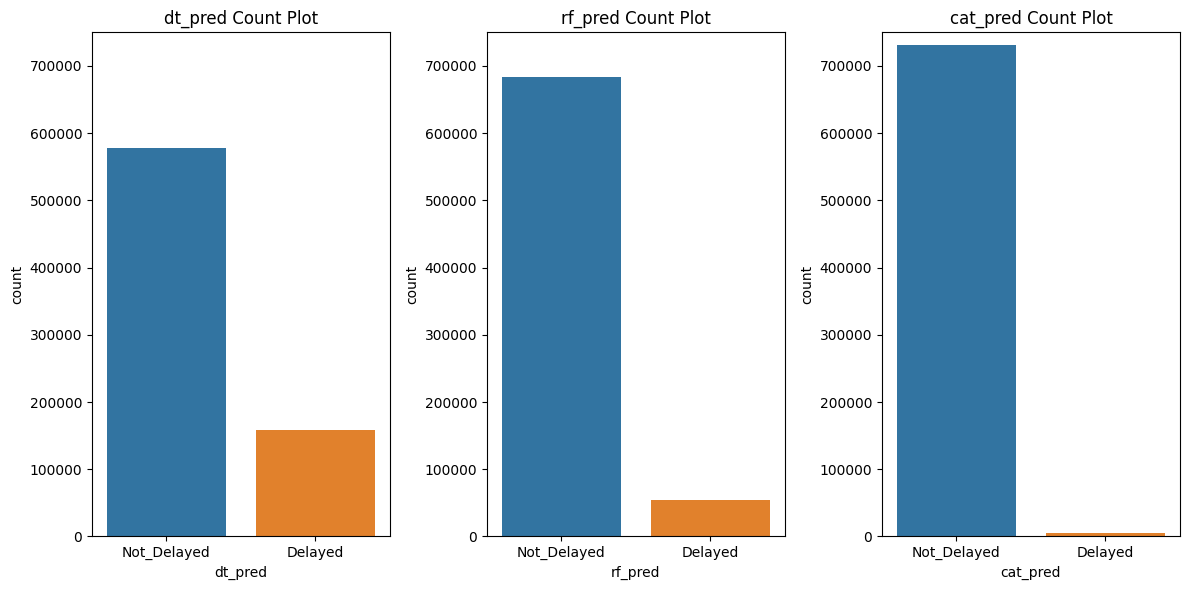

In [107]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=df_pred, x='dt_pred')
plt.ylim(0, 750000)
plt.title('dt_pred Count Plot')

plt.subplot(1, 3, 2)
sns.countplot(data=df_pred, x='rf_pred')
plt.ylim(0, 750000)
plt.title('rf_pred Count Plot')

plt.subplot(1, 3, 3)
sns.countplot(data=df_pred, x='cat_pred')
plt.ylim(0, 750000)
plt.title('cat_pred Count Plot')

plt.tight_layout()
plt.show()

In [47]:
# 세 개의 열의 값이 모두 다른 행을 필터링합니다.
filtered_rows = df_pred[(df_pred['dt_pred'] != df_pred['rf_pred']) |
                        (df_pred['rf_pred'] != df_pred['cat_pred']) |
                        (df_pred['dt_pred'] != df_pred['cat_pred'])]


In [48]:
filtered_rows

,dt_pred,rf_pred,cat_pred
2,Delayed,Not_Delayed,Not_Delayed
8,Delayed,Not_Delayed,Not_Delayed
17,Delayed,Not_Delayed,Not_Delayed
21,Delayed,Not_Delayed,Not_Delayed
24,Delayed,Not_Delayed,Not_Delayed
...,...,...,...
988278,Delayed,Not_Delayed,Not_Delayed
988280,Delayed,Delayed,Not_Delayed
988294,Delayed,Not_Delayed,Not_Delayed
988303,Delayed,Not_Delayed,Not_Delayed


## Voting

In [60]:
X_unlabeled_vote = X_unlabeled.copy()

In [ ]:
from sklearn.ensemble import VotingClassifier

# 보팅 모델을 초기화
vote = VotingClassifier(estimators=[
    ('dt', dt),  # Decision Tree 모델
    ('rf', rf),  # Random Forest 모델
    ('cat', cat) # CatBoost 모델
], voting='hard')  # 다수결 보팅 방식을 선택


vote.fit(X_labeled, y_labeled)

In [61]:
X_unlabeled_vote['Delay_pred'] = vote.predict(X_unlabeled_vote)


In [62]:
X_unlabeled_vote['Delay_pred'].value_counts()

Not_Delayed    688937
Delayed         47405
Name: Delay_pred, dtype: int64

In [63]:
# train_lb의 'Delay'칼럼값이 -1인 레이블값 예측값으로 채우기
for i in range(len(X_unlabeled_vote)):
  row_index=X_unlabeled_vote['Delay_pred'].index[i]
  train.loc[row_index,'Delay']=X_unlabeled_vote['Delay_pred'].iloc[i]

In [71]:
train['Delay'].value_counts()

Not_Delayed    896426
Delayed         91886
Name: Delay, dtype: int64

## oversampling

In [72]:
x_train = train.drop('Delay', axis = 1)
y_train = train['Delay']

In [73]:
pd.Series(y_train).value_counts()

Not_Delayed    896426
Delayed         91886
Name: Delay, dtype: int64

In [74]:
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)



In [77]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
s_y_train_encoded = le.transform(s_y_train)

# 변환된 값 출력
print('전 : ', np.bincount(y_train_encoded))
print('후 : ', np.bincount(s_y_train_encoded))

전 :  [ 91886 896426]
후 :  [896426 896426]


## 지도학습

###   Logistic Regression

In [80]:
lr = LogisticRegression()
lr.fit(s_x_train, s_y_train)

LogisticRegression()

In [86]:
y_pred_lr = lr.predict_proba(test_k)

# 제출

In [96]:
submission = pd.DataFrame(data=y_pred_lr, columns=sample_submission.columns, index=sample_submission.index)

In [97]:
submission.head(3)

,Not_Delayed,Delayed
ID,,
TEST_000000,0.481750,0.518250
TEST_000001,0.501718,0.498282
TEST_000002,0.561916,0.438084


In [98]:
submission.to_csv('./submission.csv', index=True)